# Следење на контакти

**Progress of an epidemic**

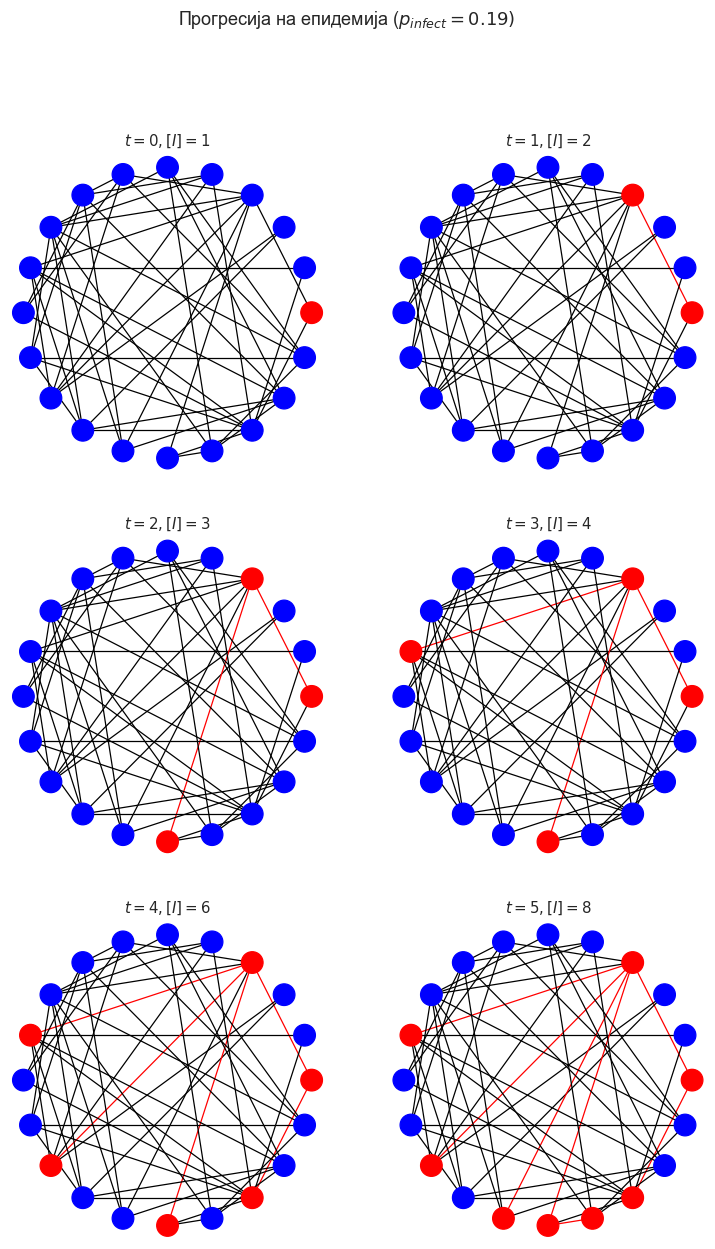

In [3]:
"""

 Created on 20-Feb-21
 @author: Kiril Zelenkovski

"""
import numpy
import networkx
import epyc
import epydemic
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import seaborn

matplotlib.rcParams['figure.dpi'] = 90
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1)


def stepEpidemic(g):
    # keep track of progress in this timestep
    inf = []

    # extract all the infected ndoes
    infecteds = [n for n in g.nodes
                 if 'infected' in g.nodes[n].keys()]

    # advance the epidemic
    for n in infecteds:
        infs = []
        if 'infected' in g.nodes[n].keys():
            # infect every susceptible neighbour
            # with probability pInfect
            for m in g.neighbors(n):
                # ignore already-infected neighbours
                if 'infected' not in g.nodes[m].keys():
                    # decide whether to infect or not
                    if numpy.random.random() < pInfect:
                        # we're infecting, record this
                        # and the edge the infection traversed
                        g.nodes[m]['infected'] = True
                        infs.append(m)
                        g.edges[n, m]['occupied'] = True

        # record the infection mapping
        if len(infs) > 0:
            inf.append((n, infs))

    # return the mapping of who infected whom
    return inf


def drawEpidemic(g, ax, t):
    # compute node colours
    inf = 0
    nodes = list(g.nodes)
    ncs = ['blue'] * len(nodes)
    for i in range(len(nodes)):
        n = nodes[i]
        if 'infected' in g.nodes[n].keys():
            ncs[i] = 'red'
            inf += 1

    # compute edge colours
    edges = list(g.edges)
    ecs = ['black'] * len(edges)
    for i in range(len(edges)):
        (n, m) = edges[i]
        if 'occupied' in g.edges[n, m].keys():
            ecs[i] = 'red'

    # draw the contact tree
    networkx.draw_circular(g, ax=ax,
                           node_color=ncs, edge_color=ecs)
    ax.set_title('$t = {t}, [I] = {i}$'.format(t=t, i=inf))


(fig, axs) = plt.subplots(3, 2, figsize=(10, 16))

# build a small ER contact network
N = 20
pEdge = 0.25
g = networkx.gnp_random_graph(N, pEdge)

# infect a single person
g.nodes[0]['infected'] = True
infs = [[(None, [0])]]

pInfect = 0.19

t = 0
for x in range(3):
    for y in range(2):
        # draw the infected nodes and tramission edges
        ax = axs[x][y]
        drawEpidemic(g, ax, t)

        # advance the epidemic
        infs.append(stepEpidemic(g))
        t += 1

# fine-tune the figure
plt.suptitle('Прогресија на епидемија ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))
plt.savefig('images/3_1_Epidemic-progress.png')
plt.show()

**Contact trees**

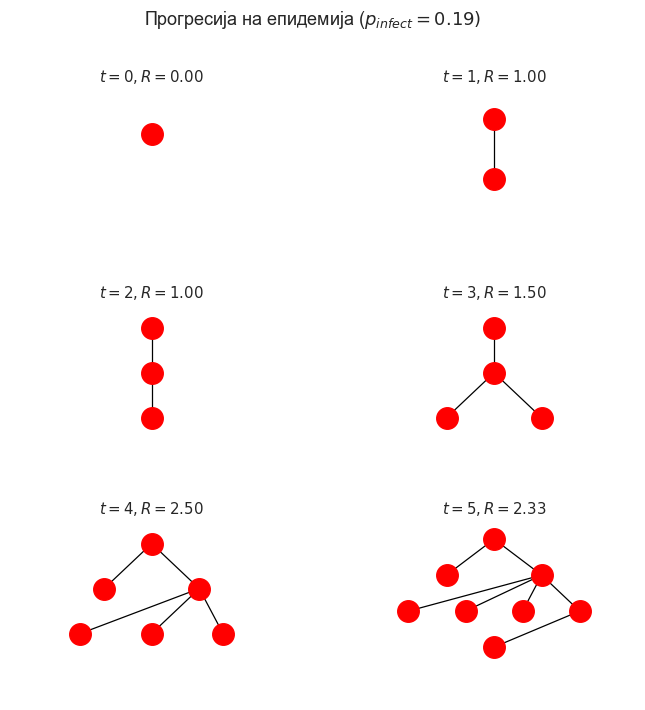

In [4]:
def drawContactTree(ax, t, ct):
    # turn the infection list into a network
    g = networkx.Graph()
    for infs in ct:
        for (n, ms) in infs:
            for m in ms:
                g.add_node(m)
                if n is not None:
                    g.add_edge(n, m)

    # compute the layers in the tree and the number of
    # infections from each individual
    secondaries = dict()
    ns = [0]
    layers = [ns]
    while len(ns) > 0:
        layer = []
        for n in ns:
            gs = set(g.neighbors(n))
            if len(layers) > 1:
                gs -= set(layers[-2])
            layer.append(list(gs))
            if len(gs) > 0:
                secondaries[n] = len(gs)
        ns = [n for cs in layer for n in cs]
        if len(ns) > 0:
            layers.append(ns)

    # compute locations
    pos = dict()
    dy = 1.0 / (len(layers) + 1)
    y = 1.0 - dy / 2
    for layer in layers:
        dx = 1.0 / (len(layer) + 1)
        x = dx
        for n in layer:
            pos[n] = (x, y)
            x += dx
        y -= dy

    # compute R_t
    if len(secondaries.keys()) > 0:
        Rt = sum(secondaries.values()) / len(secondaries.keys())
    else:
        Rt = 0

    # draw the tree
    networkx.draw_networkx(g, pos, ax=ax,
                           node_color='red', with_labels=False)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.axis('off')
    ax.set_title('$t = {t}, R = {rt:.2f}$'.format(t=t, rt=Rt))


(fig, axs) = plt.subplots(3, 2, figsize=(9, 9))

t = 0
for x in range(3):
    for y in range(2):
        ax = axs[x][y]
        layers = infs[:(t + 1)]
        drawContactTree(ax, t, layers)
        t += 1

# fine-tune the figure
plt.suptitle('Прогресија на епидемија ($p_{\\mathit{infect}} = ' + '{i})$'.format(i=pInfect))
plt.savefig('images/3_2_Contact-tree.png')
plt.show()